In [3]:
import numpy as np
import pulp as plp
import random
import matplotlib.pyplot as plt
import time
import networkx as nx
from tqdm import tqdm
%matplotlib notebook

In [4]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

In [5]:
def color_of_frustration(G):
    
    positive=0
    negative=0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            
            if G.nodes[n1]['color'] == G.nodes[n2]['color'] == "Black":
                negative +=1
            else:
                positive +=1
    return positive,negative

In [6]:
def FG0(N,k):

    #G = nx.triangular_lattice_graph(N,N)
    G = nx.grid_2d_graph(N,N)
    #G = nx.path_graph(N)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    #nx.set_node_attributes(G,pos,'pos')
    
    return G

In [7]:
def Rewire(N,k):

    G = FG(N,k)

    #Properties(G)
    a = frustration_count(G)
    
    #################################################################################################
    
    H = nx.algorithms.double_edge_swap(G.copy(), nswap=1)
    #print("#"*100)
          
    #################################################################################################    
    
    #Properties(H)
    b = frustration_count(H)
    
    if a == b:
        return 0
    if b > a:
        return 2
    if b < a:
        return -2

    print("end")

In [8]:
def Calculate_Probabilites(size,prop):
    probabilites = []
    edges = []
    for i in range(10):
        avg=[]
        for k in tqdm(range(1000)):

            H = FG(size,prop)

            edges.append(len(H.copy().edges()))
            f = frustration_count(H.copy())
            avg.append(f)

        prob=[]
        for i in range(0,max(edges)):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)

    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/1000,np.std(total[:,i])/1000))

    return np.array(final)

In [14]:
probabilites=Calculate_Probabilites(4,0.5)
values = probabilites[:,0]
errors = probabilites[:,1]

100%|██████████| 1000/1000 [00:00<00:00, 3424.51it/s]


In [15]:
print(values)
print(errors)

[0.     0.     0.     0.0013 0.0031 0.0065 0.0143 0.0283 0.0662 0.105
 0.1437 0.1705 0.183  0.1321 0.0721 0.0429 0.0215 0.0058 0.0026 0.
 0.0011 0.     0.     0.    ]
[0.         0.         0.         0.0009     0.00113578 0.00241868
 0.00453982 0.00481768 0.00955824 0.00886566 0.00705762 0.01361066
 0.00847349 0.00544885 0.00692026 0.00756902 0.00447772 0.0018868
 0.0012     0.         0.0009434  0.         0.         0.        ]


<IPython.core.display.Javascript object>


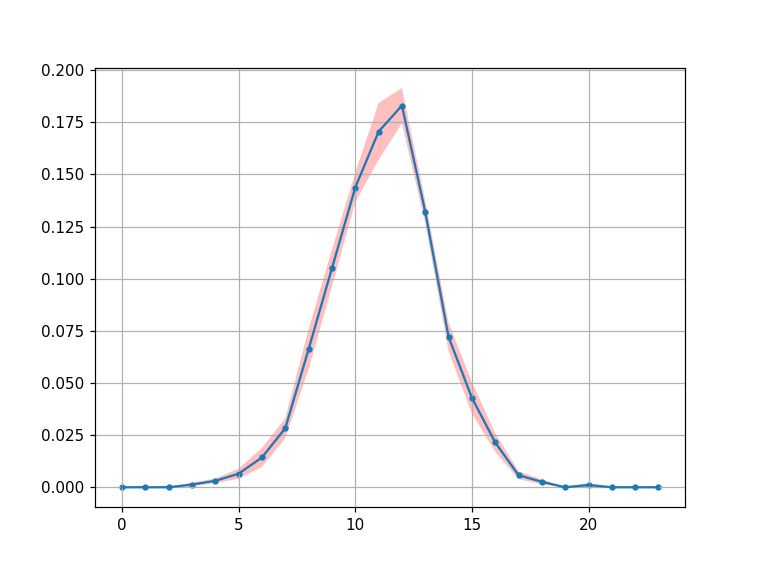

In [16]:
fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,capsize=1)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()
#ax.set_xlim(50,125)

# How to set Delta parameter

In [9]:
def Properties(G):
    positive,negative = color_of_frustration(G)
    
    print("N: ",len(G.nodes()))
    print("L: ",len(G.edges()))

    node_colors=nx.get_node_attributes(G,'color')
    #print("Black: ",len([i for i in node_colors.values() if i=="Black"]))
    #print("White: ",len([i for i in node_colors.values() if i=="Silver"])) 
    print("f: ",frustration_count(G))
    print("L-f: ",len(G.edges())-frustration_count(G))

    print("f+: ",positive)
    print("f-: ",negative)
    
    print("Delta: ",positive-negative)
    print("Abs(Delta): ",int(np.sqrt((positive-negative)**2)))

    print(frustration_count(G)/len(G.edges()))

In [10]:
def FG(N,k):

    #G = nx.triangular_lattice_graph(N,N)
    G = nx.grid_2d_graph(N,N)
    #G = nx.path_graph(N)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    
    return G

In [132]:
Properties(FG(5,0.5))

N:  25
L:  40
f:  18
L-f:  22
f+:  10
f-:  8
Delta:  2
Abs(Delta):  2
0.45


## Simulated Annealing Algorithm

In [61]:
from random import choice
from random import sample

from IPython.display import display, Math

G = FG(5,0.5)
print("L=",len(G.edges()))

Target = 40

p,n = color_of_frustration(G)
d = int(np.sqrt((p-n)**2))
print("Abs(Delta): ",d)

D_array = []
for k in range(10):
    print("k=",k)
    H = G.copy()
    random_node = sample(H.nodes(),1)[0]
    print("\t",random_node)
    print("\t",G.nodes[random_node]['color'])
    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        H.nodes[random_node]['color'] = "Black"
    else:
        H.nodes[random_node]['color'] = "Silver"
    print("\t",H.nodes[random_node]['color'])
    
    p,n = color_of_frustration(H)
    d_new = int(np.sqrt((p-n)**2))
    print("\td =",d_new)
    
    if np.abs(Target-d_new) < np.abs(Target-d):
        D_array.append((random_node,np.abs(Target-d_new)))

L= 40
Abs(Delta):  0
k= 0
	 (3, 2)
	 Black
	 Silver
	d = 4
k= 1
	 (3, 0)
	 Silver
	 Black
	d = 3
k= 2
	 (2, 0)
	 Black
	 Silver
	d = 3
k= 3
	 (2, 3)
	 Silver
	 Black
	d = 4
k= 4
	 (3, 3)
	 Black
	 Silver
	d = 4
k= 5
	 (4, 3)
	 Silver
	 Black
	d = 3
k= 6
	 (2, 1)
	 Black
	 Silver
	d = 4
k= 7
	 (3, 4)
	 Silver
	 Black
	d = 3
k= 8
	 (1, 0)
	 Silver
	 Black
	d = 3
k= 9
	 (1, 1)
	 Black
	 Silver
	d = 4


In [89]:
Min = len(G.edges())+1
D_array = np.array(D_array)

ind = 0
for index,(node,dd) in enumerate(D_array):
    if dd < Min:
        print(dd,Min,index)
        Min = dd
        ind = index
    
D_array[0][0]

36 41 0


(3, 2)

<IPython.core.display.Javascript object>


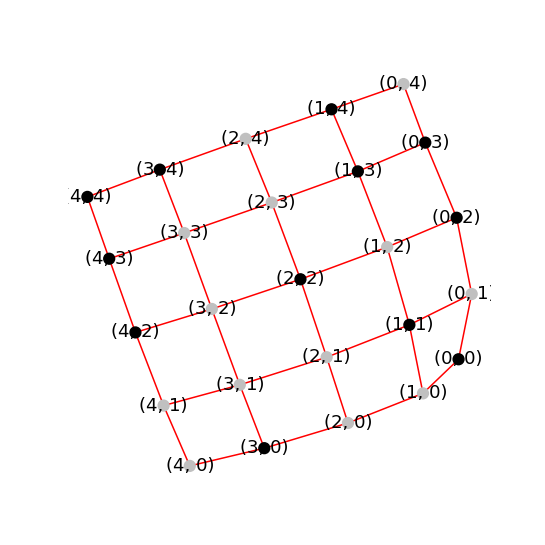

L= 40
Abs(Delta):  3
end
d_final = 23


In [11]:
from random import choice
from random import sample

from IPython.display import display, Math

G = FG(5,0.5)

pos =nx.get_node_attributes(G,'pos')
node_colors=nx.get_node_attributes(G,'color')
edge_colors=nx.get_edge_attributes(G,'edge_color')

fig, ax = plt.subplots(figsize=(5,5))
nx.draw(G,pos,node_size=50,edge_color="red",node_color=node_colors.values(),with_labels=True)

print("L=",len(G.edges()))

Target = 23

p,n = color_of_frustration(G)
d = int(np.sqrt((p-n)**2))
print("Abs(Delta): ",d)

D_array = []
for k in range(100):
#while(Target != d):
    #print("k=",k)
    H = G.copy()
    random_node = sample(H.nodes(),1)[0]
    #print("\t",random_node)
    #print("\t",G.nodes[random_node]['color'])
    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        H.nodes[random_node]['color'] = "Black"
    else:
        H.nodes[random_node]['color'] = "Silver"
    #print("\t",H.nodes[random_node]['color'])
    
    p,n = color_of_frustration(H)
    d_new = int(np.sqrt((p-n)**2))
    #print("\td_new =",d_new)
    
    if np.abs(Target-d_new) < np.abs(Target-d):
        d = d_new
        #print("\tRazlika",np.abs(Target-d_new))
        #D_array.append((random_node,np.abs(Target-d_new)))
        if G.nodes[random_node]['color'] == "Silver":
            G.nodes[random_node]['color'] = "Black"
        else:
            G.nodes[random_node]['color'] = "Silver"

print("end")
p,n = color_of_frustration(G)
d_final = int(np.sqrt((p-n)**2))
print("d_final =",d_final)

<IPython.core.display.Javascript object>


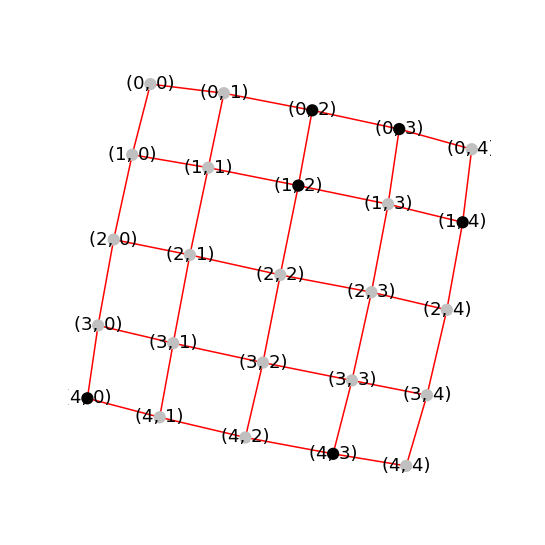

In [179]:
pos =nx.get_node_attributes(G,'pos')
node_colors=nx.get_node_attributes(G,'color')
edge_colors=nx.get_edge_attributes(G,'edge_color')

fig, ax = plt.subplots(figsize=(5,5))
nx.draw(G,pos,node_size=50,edge_color="red",node_color=node_colors.values(),with_labels=True)


# Short Annealing Code

In [276]:
from random import sample

G = FG(5,0.5)

def Anneal(G,Target):

    p,n = color_of_frustration(G)
    d = int(np.sqrt((p-n)**2))

    D_array = []
    #for k in range(200):
    #i=0
    while(d != Target):
        #print(i)
        H = G.copy()
        random_node = sample(H.nodes(),1)[0]
        chosen_color = G.nodes[random_node]['color']
        if chosen_color == "Silver":
            H.nodes[random_node]['color'] = "Black"
        else:
            H.nodes[random_node]['color'] = "Silver"

        p,n = color_of_frustration(H)
        d_new = int(np.sqrt((p-n)**2))
        

        if np.abs(Target-d_new) < np.abs(Target-d):
            d = d_new
            if G.nodes[random_node]['color'] == "Silver":
                G.nodes[random_node]['color'] = "Black"
            else:
                G.nodes[random_node]['color'] = "Silver"
        #i+=1
    return G.copy()

In [12]:

F = FG(5,0.5)
Target = 40

G = Anneal(F,Target)

p,n = color_of_frustration(G)
d_final = int(np.sqrt((p-n)**2))
print("d_final =",d_final)

NameError: name 'Anneal' is not defined

In [253]:
L = 40
print(int(0*L),int(1/4*L),int(L/2),int(3/4*L),int(L))
print(int(0*(L-1)),int(1/4*(L-1)),int((L-1)/2),int(3/4*(L-1)),int(L-1))

0 10 20 30 40
0 9 19 29 39


# Fixed Annealing Algorithm

In [288]:
#https://medium.com/swlh/how-to-implement-simulated-annealing-algorithm-in-python-ab196c2f56a0

import random
import math

def simulated_annealing(initial_state):
    """Peforms simulated annealing to find a solution"""
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    # Start by initializing the current state with the initial state
    current_state = initial_state
    solution = current_state

    while current_temp > final_temp:
        neighbor = random.choice(get_neighbors())

        # Check if neighbor is best so far
        cost_diff = get_cost(self.current_state) - get_cost(neighbor)

        # if the new solution is better, accept it
        if cost_diff > 0:
            solution = neighbor
        # if the new solution is not better, accept it with a probability of e^(-cost/temp)
        else:
            if random.uniform(0, 1) < math.exp(-cost_diff / current_temp):
                solution = neighbor
        # decrement the temperature
        current_temp -= alpha

    return solution

def get_cost(state):
    """Calculates cost of the argument state for your solution."""
    raise NotImplementedError
    
def get_neighbors(state):
    """Returns neighbors of the argument state for your solution."""
    raise NotImplementedError
    

In [136]:
import random
import math

def simulated_annealing(G,target):
    """Peforms simulated annealing to find a solution"""
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

def change(G,random_node):

    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        G.nodes[random_node]['color'] = "Black"
    else:
        G.nodes[random_node]['color'] = "Silver"
    
    return G.copy()

def get_cost(target,new):

    return np.abs(target-new)
 
def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    return int(np.sqrt((p-n)**2))

12
d0 = 2


<IPython.core.display.Javascript object>


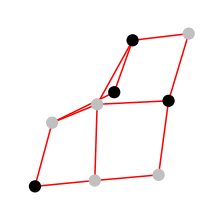

df = 12


<IPython.core.display.Javascript object>


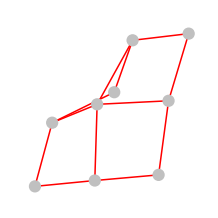

In [167]:
F = FG(3,0.5)
print(len(F.edges()))
d0 = calculate_delta(F)
print("d0 =",d0)

Plot2D(F)

H = simulated_annealing(F,target=len(F.edges()))
df = calculate_delta(H)
print("df =",df)

Plot2D(H)

In [116]:
def Plot2D(G):

    pos =nx.get_node_attributes(G,'pos')
    node_colors=nx.get_node_attributes(G,'color')
    edge_colors=nx.get_edge_attributes(G,'edge_color')

    fig, ax = plt.subplots(figsize=(2,2))
    nx.draw(G,pos,node_size=50,edge_color="red",node_color=node_colors.values(),with_labels=False)

# TESTING

In [142]:
def Calculate_Probabilites2(size,target):
    probabilites = []
    edges = []
    for i in range(10):
        avg=[]
        for k in tqdm(range(1000)):
            
            H = simulated_annealing(FG(size,0.5),target)

            edges.append(len(H.copy().edges()))
            f = frustration_count(H.copy())
            avg.append(f)

        prob=[]
        for i in range(0,max(edges)):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)

    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/1000,np.std(total[:,i])/1000))

    return np.array(final)

In [143]:
probabilites=Calculate_Probabilites2(5,9)
values = probabilites[:,0]
errors = probabilites[:,1]

100%|██████████| 1000/1000 [00:17<00:00, 58.20it/s]


<IPython.core.display.Javascript object>


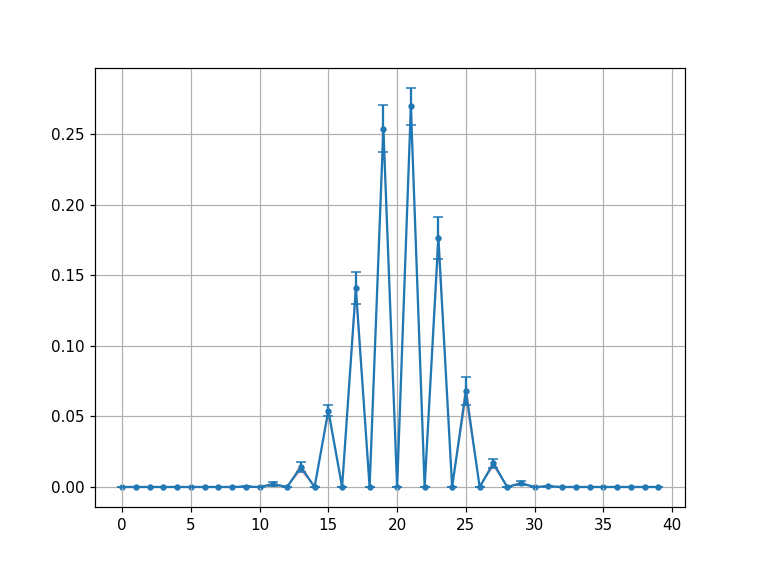

In [149]:
fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()
#ax.set_xlim(50,125)

In [173]:
probabilites=Calculate_Probabilites2(20,0)
values = probabilites[:,0]
errors = probabilites[:,1]

100%|██████████| 1000/1000 [13:50<00:00,  1.20it/s]


<IPython.core.display.Javascript object>


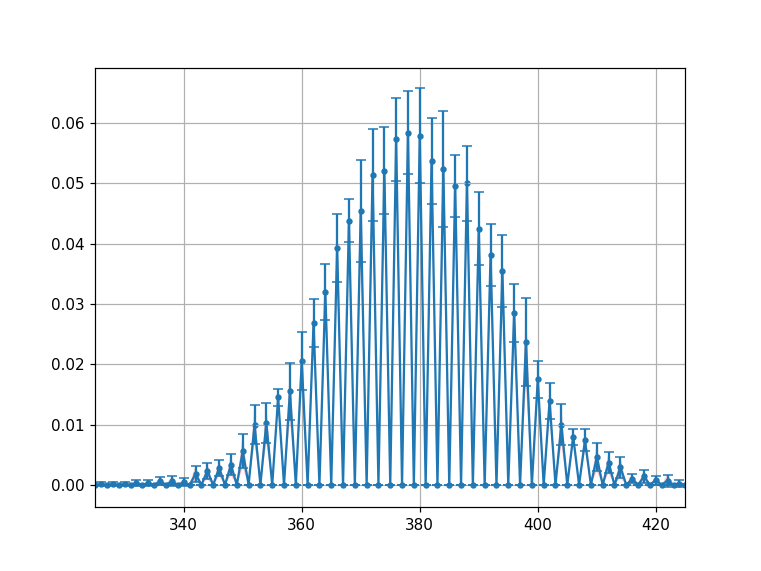

(325.0, 425.0)

In [177]:
fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()
ax.set_xlim(325,425)

In [174]:
np.save("large-graph-20.txt",probabilites)

# 5.11

In [183]:
F = FG(10,0.5)
print(len(F.edges()))

180


In [179]:
probs=Calculate_Probabilites2(10,0)
values = probs[:,0]
errors = probs[:,1]

100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]


<IPython.core.display.Javascript object>


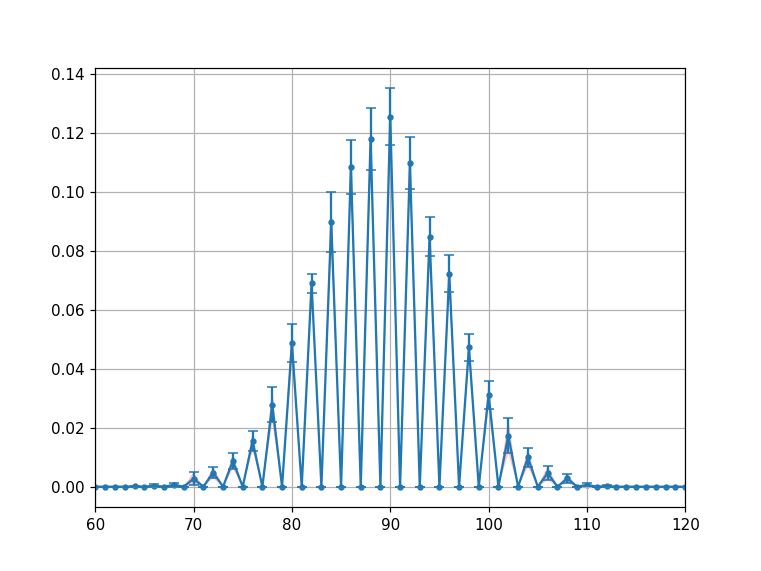

(60.0, 120.0)

In [182]:
fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()
ax.set_xlim(60,120)

In [184]:
np.save("medium-graph-10.txt",probs)

# 5.11 

In [191]:
def FAST_FG(N,k):

    #G = nx.triangular_lattice_graph(N,N)
    G = nx.grid_2d_graph(N,N)
    #G = nx.path_graph(N)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    return G

In [239]:
def Calculate_Probabilites3(size,target,edge):
    probabilites = []
    #edges = []
    for i in range(5):
        avg=[]
        for k in tqdm(range(1000)):
            
            f = frustration_count(simulated_annealing(FAST_FG(size,0.5),target))
            avg.append(f)

        prob=[]
        for i in range(edge):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)

    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/100,np.std(total[:,i])/100))

    return np.array(final)

In [240]:
F = FAST_FG(40,0.5)
probabilites=Calculate_Probabilites3(40,0,len(F.edges()))
values = probabilites[:,0]
errors = probabilites[:,1]

  0%|          | 2/1000 [00:06<52:30,  3.16s/it]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


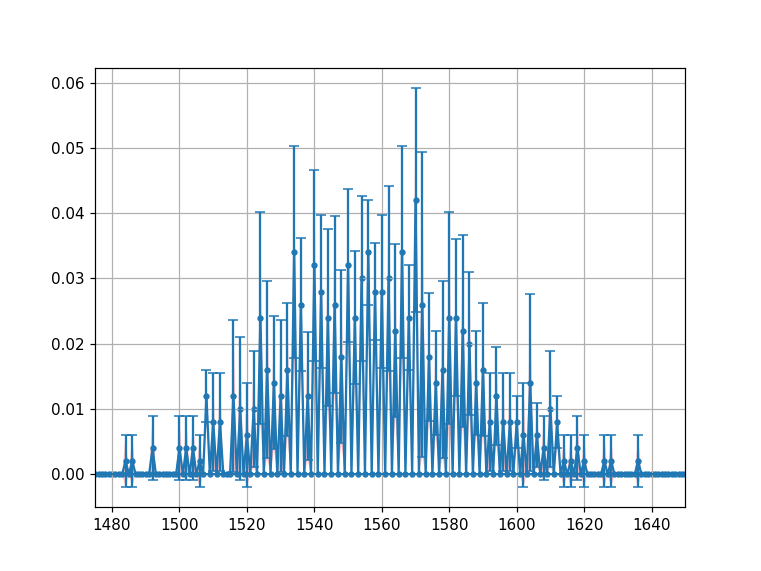

(1475.0, 1650.0)

In [237]:
fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()
ax.set_xlim(1475,1650)

In [231]:
np.save("larger-graph-40",probabilites)

In [238]:
F = FAST_FG(40,0.5)
print(len(F.edges()))

3120
